In [342]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings("ignore", message="Glyph 12 missing from current font.")



Data #1

In [343]:
data_polling = pd.read_stata("Data/cumulative_2006_2018.dta")

In [344]:
inputs = ['year','st','gender', 'age', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']
targets = ['pid3']

keep = inputs + targets

data_polling = data_polling[(data_polling.year == 2018) & (data_polling.pid3.isin(['Democrat','Republican']) )]

polling = data_polling[keep]

In [345]:
polling.dropna(axis=0, how='any',inplace=True)

In [346]:
pd.options.mode.chained_assignment = None  # default='warn'

polling['age_band'] = np.NaN
polling.loc[ (polling['age'] >= 18) & (polling['age'] <= 29), 'age_band'] = 'Young'
polling.loc[ (polling['age'] >= 30) & (polling['age'] <= 49), 'age_band'] = 'Lower-Middle'
polling.loc[ (polling['age'] >= 50) & (polling['age'] <= 69), 'age_band'] = 'Upper-Middle'
polling.loc[ (polling['age'] >= 70) , 'age_band'] = 'Old'

polling.loc[ polling['pid3'] == "Democrat", "Dem_Ind"] = 1
polling.loc[ polling['pid3'] == 'Republican', "Dem_Ind"] = 0
polling['Dem_Ind'] = polling['Dem_Ind'].astype(int)

categorical_polling = ['st','gender', 'age_band', 'race', 'hispanic', 'educ', 'faminc', 'marstat', 'economy_retro', 'newsint','approval_pres']

In [347]:
polling.head()

,year,st,gender,age,race,hispanic,educ,faminc,marstat,economy_retro,newsint,approval_pres,pid3,age_band,Dem_Ind
392756,2018,OH,Female,58,White,No,Post-Grad,150k+,Married,Stayed About The Same,Only Now And Then,Approve / Somewhat Approve,Republican,Upper-Middle,0
392757,2018,KY,Female,66,White,No,Post-Grad,10k - 20k,Divorced,Stayed About The Same,Most Of The Time,Strongly Disapprove,Democrat,Upper-Middle,1
392758,2018,AZ,Female,88,White,No,High School Graduate,20k - 30k,Widowed,Gotten Much Better,Some Of The Time,Approve / Somewhat Approve,Republican,Old,0
392760,2018,NC,Male,71,White,No,High School Graduate,50k - 60k,Married,Gotten Much Better,Some Of The Time,Strongly Approve,Republican,Old,0
392761,2018,PA,Male,86,White,No,4-Year,60k - 70k,Widowed,Gotten Better / Somewhat Better,Most Of The Time,Strongly Approve,Republican,Old,0


In [348]:
small_polling = polling.sample(n=10000, random_state = 42)

X_polling = small_polling[categorical_polling]

y_polling = small_polling.loc[:,'Dem_Ind']

Data #2

In [349]:
# Originall Retrieved From: http://archive.ics.uci.edu/ml/datasets/Adult
# CSV Retrieved From: https://www.kaggle.com/uciml/adult-census-income
# URL: https://drive.google.com/file/d/1wuWJPeacMhHQSXdITZx1_pktoU-ZRb8n/view?usp=sharing
data_income = pd.read_csv("Data/adult.csv")

print(data_income.shape)

(32561, 15)


In [350]:
# Response Variable 
data_income.loc[ data_income['income'] == ">50K", "income"] = 1
data_income.loc[ data_income['income'] == '<=50K', "income"] = 0
data_income['income'] = data_income['income'].astype(int)

In [351]:
# Feature Engineering
data_income['native_USA'] = 0 
data_income.loc[ data_income['native.country'] == "United-States", "native_USA"] = 1
data_income.loc[ data_income['native.country'] != "United-States", "native_USA"] = 0

In [352]:
data_income['native_USA'].value_counts()

1    29170
0     3391
Name: native_USA, dtype: int64

In [353]:
data_income['age_band'] = np.NaN
data_income.loc[ (data_income['age'] <= 29), 'age_band'] = 'Young'
data_income.loc[ (data_income['age'] >= 30) & (data_income['age'] <= 49), 'age_band'] = 'Lower-Middle'
data_income.loc[ (data_income['age'] >= 50) & (data_income['age'] <= 69), 'age_band'] = 'Upper-Middle'
data_income.loc[ (data_income['age'] >= 70) , 'age_band'] = 'Old'

In [354]:
data_income['hours_band'] = np.NaN
data_income.loc[ (data_income['hours.per.week']) < 40, "hours_band"] = 'Low'
data_income.loc[ (data_income['hours.per.week']) == 40, "hours_band"] = 'Average'
data_income.loc[ (data_income['hours.per.week']) > 40, "hours_band"] = 'High'

In [355]:
data_income['hours_band'].value_counts()

Average    15217
High        9581
Low         7763
Name: hours_band, dtype: int64

In [356]:
categorical_income = ['workclass','education','marital.status','occupation','relationship','race','sex','native_USA','age_band','hours_band']


In [357]:
data_income['income'].value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [358]:
small_income = data_income.sample(10000,random_state=42)

In [359]:
X_income = small_income[categorical_income]

y_income = small_income.loc[:,'income']


General Use Functions

In [360]:
from sklearn.preprocessing import OneHotEncoder

def prep_data(X, y, categoricalVars):

    encoder = OneHotEncoder(sparse=False)
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categoricalVars]))
    X_encoded.columns = encoder.get_feature_names(categoricalVars)
    X.drop(categoricalVars, axis = 1, inplace = True)
    if X.shape[1] > 0:
        OH_X = pd.concat([X, pd.DataFrame(X_encoded, index=X.index)], axis = 1)
    else:
        OH_X = X_encoded 
        
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(OH_X, y, test_size = .30, train_size = .70, random_state = 42)
    return(X_Train, X_Test, Y_Train, Y_Test)

In [361]:
X_Train_Polling, X_Test_Polling, Y_Train_Polling, Y_Test_Polling = prep_data(X_polling, y_polling, categorical_polling)

In [362]:
X_Train_Income, X_Test_Income, Y_Train_Income, Y_Test_Income = prep_data(X_income, y_income, categorical_income)

### Tutorial for K-Means

Selecting the Number of clusters with silhouette analysis on KMeans Clustering

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

- Silhoutte is a metric used to measure the separation distance between clusters 
- Silhoutte measure ranges from -1 to 1. 
- Silhoutte values near +1: good, sample is far from neighboring cluster
- Silhoutte values near 0: Samples is on or near the decision boundary between two clusters 
- Silhoutte values < 0: Bad, Samples may be assigned to wrong cluster 
- Vary the n_clusters and examine silhoutte metric 

In [363]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import numpy as np 

X, y = make_blobs(n_samples = 500, n_features = 2, centers = 4, cluster_std = 1, center_box = (-10.0, 10.0), shuffle = True, random_state = 1)

print(X.shape)
print(y.shape)

(500, 2)
(500,)


In [364]:
range_n_clusters = [2, 3, 4, 5, 6]

For N clusters: 2 ,The Average silhouette score is : 0.7049787496083262
For N clusters: 3 ,The Average silhouette score is : 0.5882004012129721
For N clusters: 4 ,The Average silhouette score is : 0.6505186632729437
For N clusters: 5 ,The Average silhouette score is : 0.5745566973301872
For N clusters: 6 ,The Average silhouette score is : 0.4387644975296138


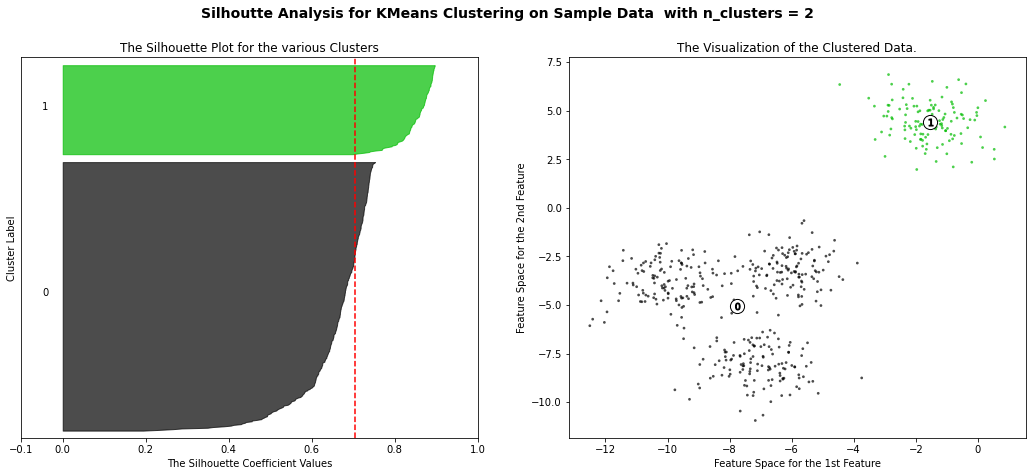

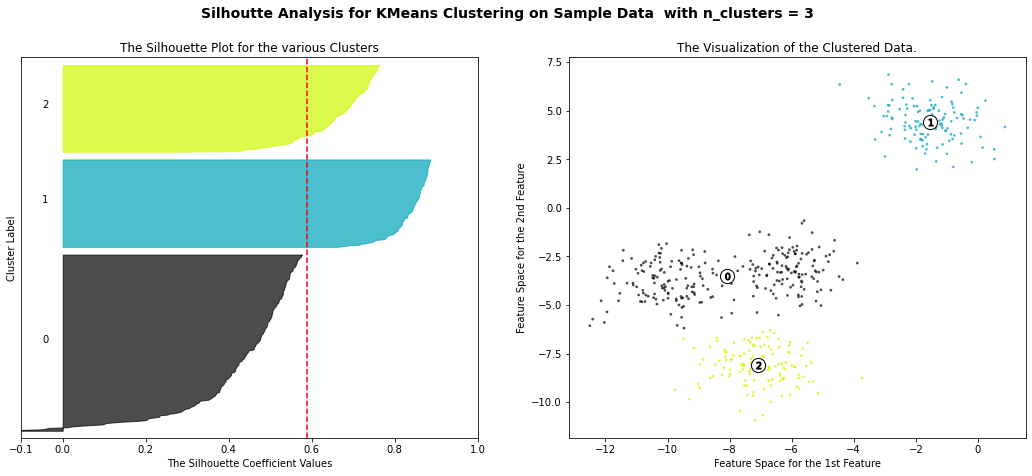

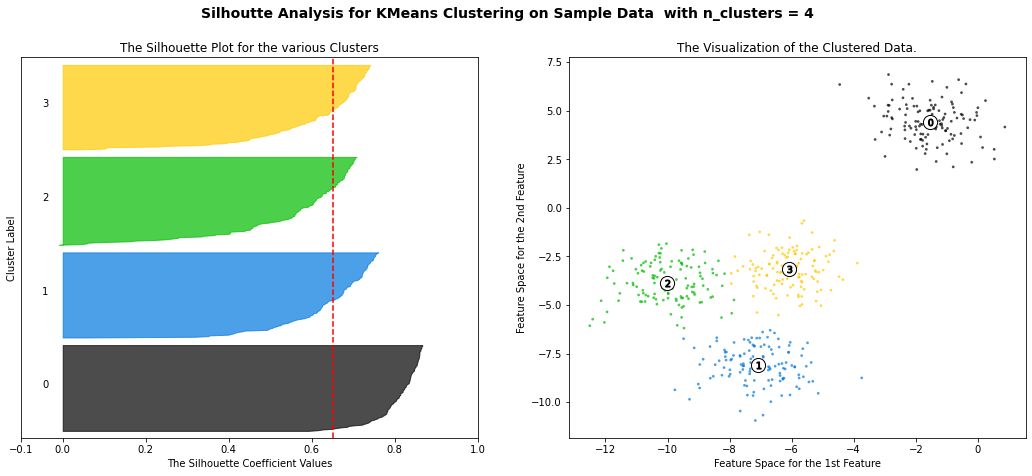

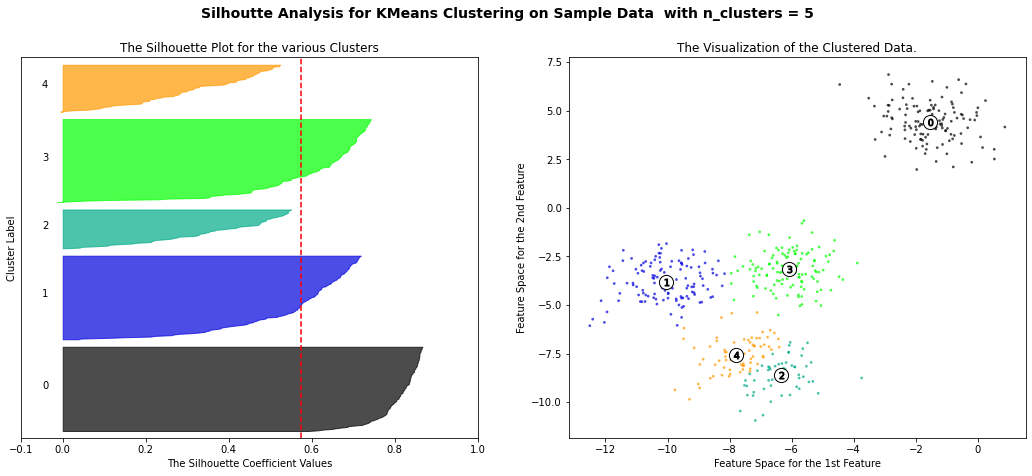

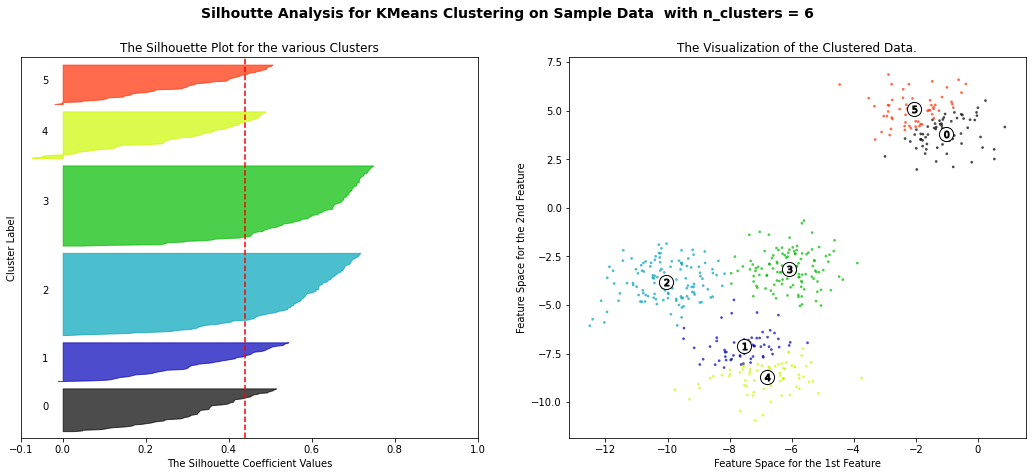

In [365]:
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Silhouette Plot 
    ax1.set_xlim([-.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1)*10])
    
    # initialize the clusterer with the n_clusters value 
    clusterer = KMeans(n_clusters=n_clusters, random_state = 10)
    cluster_labels = clusterer.fit_predict(X)
    
    # Silhouette_score gives avg value for all samples 
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For N clusters:", n_clusters, ",The Average silhouette score is :", silhouette_avg)
    
    # Get Silhouette Scores for each sample 
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        
        # Aggregate scores for samples in the ith cluster, and sort 
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                         facecolor = color, edgecolor = color, alpha = 0.7)
        
        # Label the silhouette plots with the cluster number in the middle 
        ax1.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
        
        # Computer the new y_lower for the next plot 
        y_lower = y_upper + 10 # Without this step, plots are all on top of each other 
        
    ax1.set_title("The Silhouette Plot for the various Clusters")
    ax1.set_xlabel("The Silhouette Coefficient Values")
    ax1.set_ylabel("Cluster Label")
    
    # The Vertical Line for avg. Silhouette Score of all the values 
    ax1.axvline(x = silhouette_avg, color = 'red', linestyle = "--")
    
    ax1.set_yticks([]) # Clear the Y Axis 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd Plot shows the actual clusters formed 
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker = ".", s=30, lw=0, alpha=0.7,
               c = colors, edgecolor = 'k')

    # Label the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers 
    ax2.scatter(centers[:, 0], centers[:, 1], marker = 'o', 
               c = 'white', alpha = 1, s = 200, edgecolor = 'k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker = '$%d$' % i, alpha = 1, 
                   s = 50, edgecolor = 'k')
    
    ax2.set_title("The Visualization of the Clustered Data.")
    ax2.set_xlabel("Feature Space for the 1st Feature")
    ax2.set_ylabel("Feature Space for the 2nd Feature")
    
    plt.suptitle(("Silhoutte Analysis for KMeans Clustering on Sample Data "
                    " with n_clusters = %d" %n_clusters),
                fontsize = 14, fontweight = 'bold')
    
    
plt.show()

#### Demo K-Means Clustering with MNIST Digits

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In [366]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

X_digits, y_digits = load_digits(return_X_y=True)

data = scale(X_digits)

n_samples, n_features = data.shape
n_digits = len(np.unique(y_digits))
labels = n_digits

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
     % (n_digits, n_samples, n_features))

print(82 * '_')

print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    
    #print(estimator.inertia_) 
    #print(metrics.homogeneity_score(y_digits, estimator.labels_))
  
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
      % (name, (time() - t0), estimator.inertia_,
         metrics.homogeneity_score(y_digits, estimator.labels_),
         metrics.completeness_score(y_digits, estimator.labels_),
         metrics.v_measure_score(y_digits, estimator.labels_),
         metrics.adjusted_rand_score(y_digits, estimator.labels_),
         metrics.adjusted_mutual_info_score(y_digits,  estimator.labels_),
         metrics.silhouette_score(data, estimator.labels_,
                                  metric='euclidean',
                                  sample_size=sample_size)))
    


bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(82 * '_')


n_digits: 10, 	 n_samples 1797, 	 n_features 64
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.18s	69510	0.610	0.657	0.633	0.481	0.629	0.129
random   	0.16s	69907	0.633	0.674	0.653	0.518	0.649	0.131
PCA-based	0.02s	70768	0.668	0.695	0.681	0.558	0.678	0.142
__________________________________________________________________________________


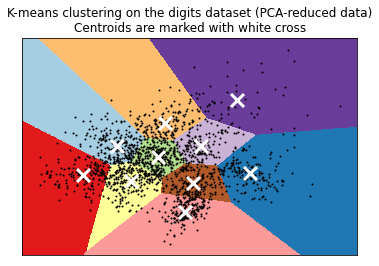

In [367]:
# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

## Step 1

#### KMeans Data 1

In [368]:
X_Train_Polling.shape

(7000, 108)

In [369]:
range_num_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_num_clusters:
    kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)

    kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Train_Polling)

    # Silhouette_score gives avg value for all samples 
    kmeans_silhouette_avg = silhouette_score(X_Train_Polling, kmeans_cluster_labels)

    print("For N clusters:", n_clusters, ", Average silhouette score is :", kmeans_silhouette_avg, \
          ", Average inertia is :", kmeans_clusterer.inertia_)
    


For N clusters: 2 , Average silhouette score is : 0.07331336447494478 , Average inertia is : 45778.57030885092
For N clusters: 3 , Average silhouette score is : 0.06931835983425738 , Average inertia is : 43601.240520956344
For N clusters: 4 , Average silhouette score is : 0.06800304818421343 , Average inertia is : 42141.844130346675
For N clusters: 5 , Average silhouette score is : 0.06552256858749685 , Average inertia is : 40931.666277083066
For N clusters: 6 , Average silhouette score is : 0.06359700822605553 , Average inertia is : 40124.14832203976
For N clusters: 7 , Average silhouette score is : 0.0631561306847906 , Average inertia is : 39341.59188891308
For N clusters: 8 , Average silhouette score is : 0.06050658266747885 , Average inertia is : 38723.01545250349
For N clusters: 9 , Average silhouette score is : 0.05884938013158652 , Average inertia is : 38210.950046129175
For N clusters: 10 , Average silhouette score is : 0.060330742611182174 , Average inertia is : 37717.99772766

#### KMeans Data 2

In [370]:
X_Train_Income.shape

(7000, 69)

In [371]:
range_num_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
#range_num_clusters = np.arange(2, 25, 1)

for n_clusters in range_num_clusters:
    kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)

    kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Train_Income)

    # Silhouette_score gives avg value for all samples 
    kmeans_silhouette_avg = silhouette_score(X_Train_Polling, kmeans_cluster_labels)

    print("For N clusters:", n_clusters, ", Average silhouette score is :", kmeans_silhouette_avg, \
          ", Average inertia is :", kmeans_clusterer.inertia_)

For N clusters: 2 , Average silhouette score is : -7.048934840719281e-05 , Average inertia is : 34566.755556981225
For N clusters: 3 , Average silhouette score is : -0.000993558568090272 , Average inertia is : 32129.37373747313
For N clusters: 4 , Average silhouette score is : -0.0019629140634428747 , Average inertia is : 30695.43289851773
For N clusters: 5 , Average silhouette score is : -0.002573010330571771 , Average inertia is : 29493.822306518105
For N clusters: 6 , Average silhouette score is : -0.003469623084750927 , Average inertia is : 28733.097248083366
For N clusters: 7 , Average silhouette score is : -0.0042014268230241856 , Average inertia is : 28009.679347735713
For N clusters: 8 , Average silhouette score is : -0.006397141986538745 , Average inertia is : 27412.545538642382
For N clusters: 9 , Average silhouette score is : -0.006479075597232962 , Average inertia is : 26867.05776968403
For N clusters: 10 , Average silhouette score is : -0.008893968951124062 , Average inert

In [571]:
def run_kmeans(X_Data, range_num_clusters, title):
      
    n_clusters_list = []
    inertia_list = []
    avg_silhouette_list = []
    
    for n_clusters in range_num_clusters:
        kmeans_clusterer =  KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = 10, random_state = 42)
        kmeans_cluster_labels = kmeans_clusterer.fit_predict(X_Data)
        kmeans_silhouette_avg = silhouette_score(X_Data, kmeans_cluster_labels)

        #print("For N clusters:", n_clusters, ", Average silhouette score is :", kmeans_silhouette_avg, \
        #      ", Average inertia is :", kmeans_clusterer.inertia_)
        
        n_clusters_list.append(n_clusters)
        inertia_list.append(kmeans_clusterer.inertia_)
        avg_silhouette_list.append(kmeans_silhouette_avg)
        
    plt.clf()
    plt.plot(n_clusters_list, inertia_list)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia (TSSE)")
    plt.title("The Effect of Number of Clusters \non Inertia for " + title)
    plt.show()
    #plt.savefig(title + "KMeans Inertia.png")
    
    plt.clf()
    plt.plot(n_clusters_list, avg_silhouette_list)
    plt.xlabel("Number of Clusters")
    plt.ylabel("Average Silhouette Score")
    plt.title("The Effect of Number of Clusters \non Silhouette for " + title)
    plt.show()

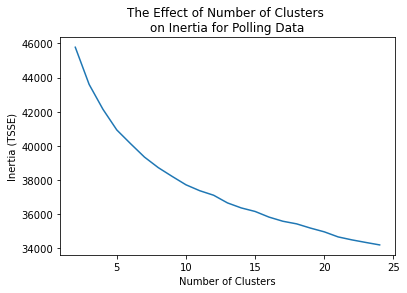

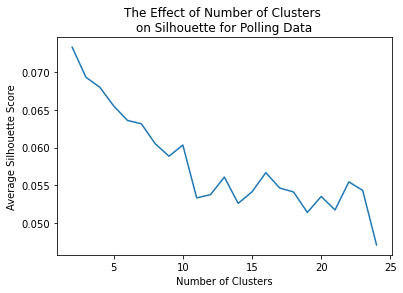

30.941965103149414


In [573]:
#kmeans_cluster(X_Train_Polling, [2, 3, 4, 5, 6, 7, 8, 9, 10], "Polling Data")
start = time.time()

run_kmeans(X_Train_Polling, np.arange(2, 25, 1) , "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

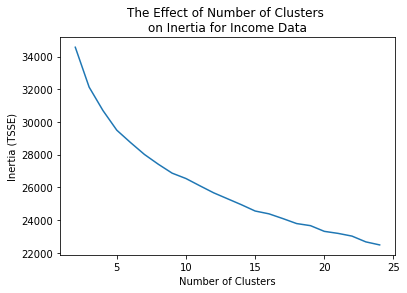

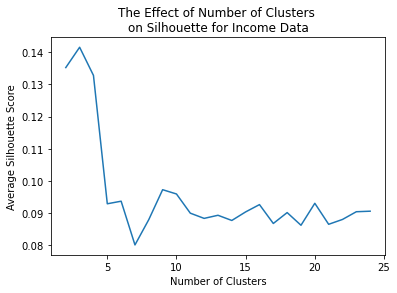

25.36522102355957


In [574]:
start = time.time()

run_kmeans(X_Train_Income, np.arange(2, 25, 1) , "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

### EM Data 1

In [375]:
from sklearn.mixture import GaussianMixture as EM

def run_em(X_Data, k_list, title, cov_type):
    
    aic_list = []
    bic_list = []
    avg_silhouette_list = []
    n_components_list = []
    
    for k in k_list:
        em = EM(n_components = k, covariance_type = cov_type, n_init = 1, init_params = 'kmeans', random_state = 42)
        em_labels = em.fit_predict(X_Data)
        
        n_components_list.append(k)
        avg_silhouette_list.append(silhouette_score(X_Data, em_labels))
        aic_list.append(em.aic(X_Data))
        bic_list.append(em.bic(X_Data))
        
    plt.clf()
    plt.plot(n_components_list, aic_list, label = 'AIC')
    plt.plot(n_components_list, bic_list, label = 'BIC')
    plt.legend()
    plt.xlabel("Number of Components")
    plt.ylabel("Metric Value")
    plt.title("The Effect of the Number of Components \non AIC/BIC for " + title + "\n With " + cov_type + " Covariance")
    plt.show()
    
    print("Silhouettes", avg_silhouette_list)
    
    plt.clf()
    plt.plot(n_components_list, avg_silhouette_list)
    plt.xlabel("Number of Components")
    plt.ylabel("Average Silhouette Score")
    plt.title("The Effect of Number of Components \non Silhouette for " + title + "\n With " + cov_type + " Covariance")
    plt.show()
    
    
        
    

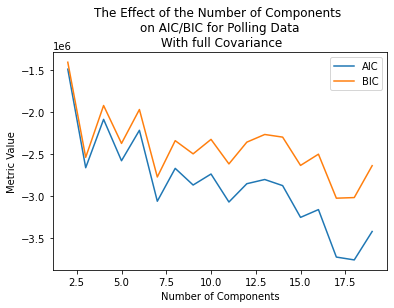

Silhouettes [0.07331336447494478, 0.00698613273306507, 0.051875038725606615, -0.011486348396113474, 0.0395297461686826, -0.006909155162600529, 0.02087705503523868, 0.030807207449398057, 0.04442399174619637, 0.005806846856362122, 0.02612208036996127, 0.01907532237477724, 0.03143621764790719, 0.01515624141556936, 0.004791346509599338, -0.017865590103383098, -0.01636469979595357, -0.001603202597543911]


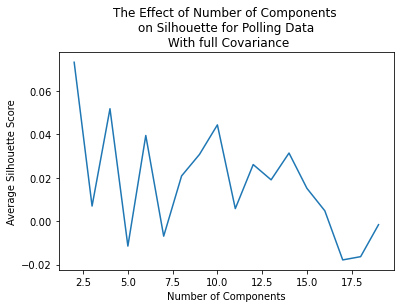

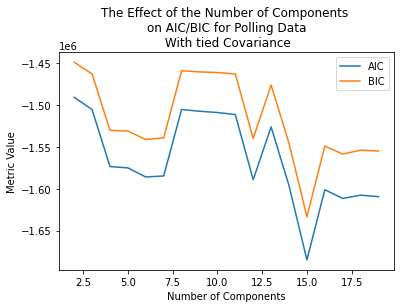

Silhouettes [0.07331336447494478, 0.06721996269174427, 0.061144973092727956, 0.05761510151333007, 0.049017821040354514, 0.05900880306291712, 0.05394549782333094, 0.05616219593945098, 0.05455892570962894, 0.05113524576640826, 0.04739678472316912, 0.04882186787949355, 0.051741714763422465, 0.0514479540990415, 0.038815191821625024, 0.039309557546586195, 0.036232231180831805, 0.039158647101756115]


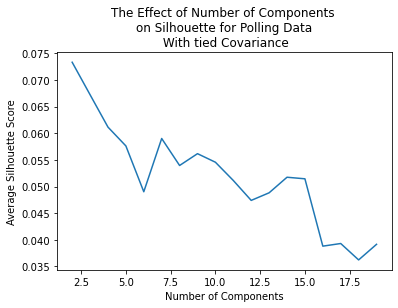

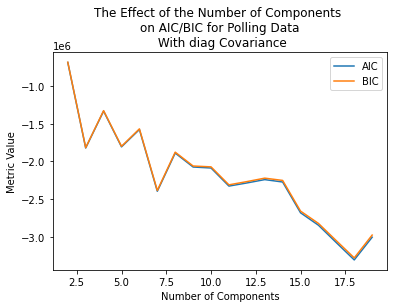

Silhouettes [0.07331336447494478, 0.03724345935510335, 0.05139313939082938, 0.0004928781304198222, 0.037907918902444965, 0.018272480677080438, 0.022731074923603573, 0.0341255237133546, 0.04370950181664999, 0.018416294748368242, 0.025374451806530588, 0.024349779398737736, 0.03169251058580869, 0.018988973678460624, 0.016941530714487323, -0.0013321921467002373, -0.00745860053538402, 0.0012698335041347148]


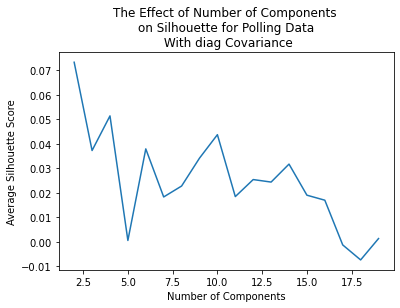

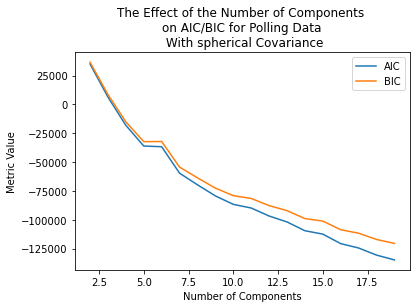

Silhouettes [0.07331336447494478, 0.06319487331299388, 0.05788294687195375, 0.05794035772127549, 0.054343712398820326, 0.05596353536647892, 0.05362456415826981, 0.04866371060659864, 0.05145438723053065, 0.046434166398708725, 0.043834215139829734, 0.04556236282355173, 0.05020698904350978, 0.040869167207301514, 0.040213613165958575, 0.03890615790370158, 0.044938132817007044, 0.04485670676258783]


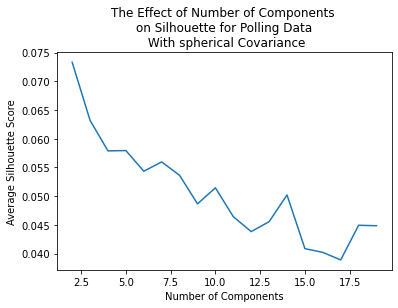

In [376]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    run_em(X_Train_Polling, np.arange(2, 20, 1), "Polling Data", cv)

Data 1:
- Silhouette Max score occurs for n_components = 2, for all cov_types, at 0.0733
- Highest Silhouette occurs for covariance type = Spherical, highest floor of 0.449 
- BIC/AIC elbow method occurs for n_components = 5, for Spherical, or 3 for others 

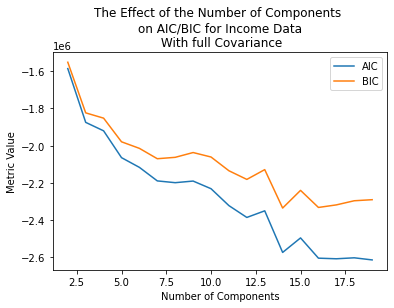

Silhouettes [0.13466498111857916, 0.13836092359564758, 0.08793029878531346, 0.07449548552431004, 0.05559578912520639, 0.0696418871081825, 0.0719009021993622, 0.07622484521388571, 0.07719048780923382, 0.07583011797204935, 0.0676358679689745, 0.07217684246711867, 0.0706457764619524, 0.08148968468868546, 0.06492725547332581, 0.07415930527298721, 0.06451834194331592, 0.06843830415526453]


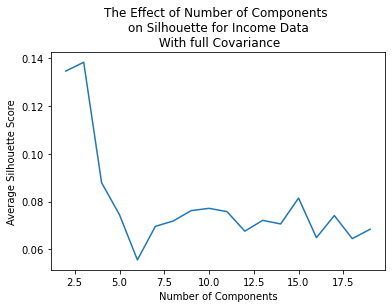

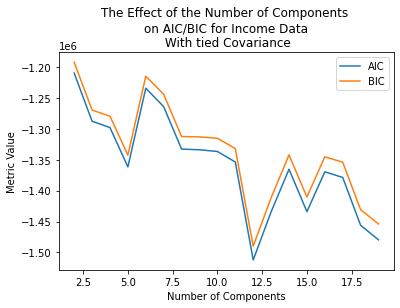

Silhouettes [0.13466498111857916, 0.14180683013810363, 0.08688430599492368, 0.08168459893983496, 0.07688809508269041, 0.07625062253123294, 0.08110905414230672, 0.08055831187923931, 0.07779972395498334, 0.08193202075677007, 0.09218553728477516, 0.08631477682390758, 0.07494092810241147, 0.08544466666748751, 0.06673471813736813, 0.08865013406361917, 0.0805279859752102, 0.09227953784360875]


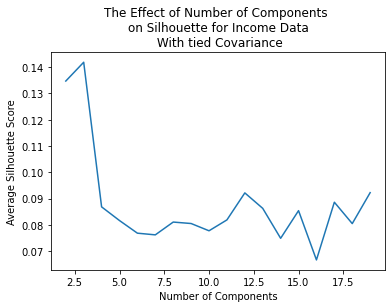

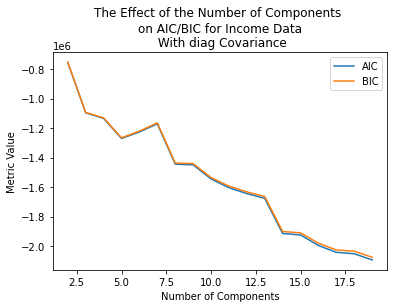

Silhouettes [0.13466498111857916, 0.14020677191000022, 0.09018733884680925, 0.0768417891854639, 0.05898306807801418, 0.07487323641414921, 0.08015193743112073, 0.07760232258075035, 0.07367240498353658, 0.07384601818803206, 0.0796725193096668, 0.07960017951468197, 0.07365748750464525, 0.08085718309545242, 0.06883531313764056, 0.07425137621506855, 0.07035544022925486, 0.06527648708112907]


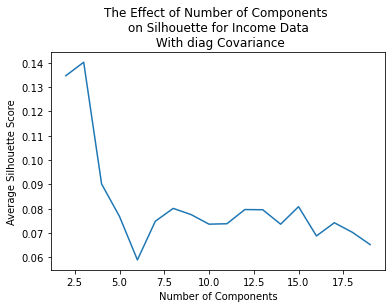

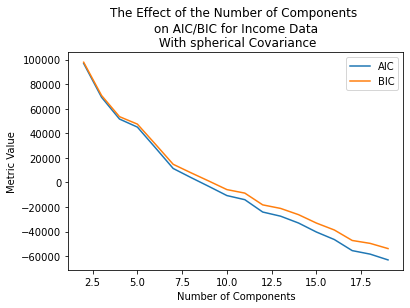

Silhouettes [0.1349776948405022, 0.14020683127411573, 0.08590614399764795, 0.07317888664953463, 0.06676861201494504, 0.07060364435543263, 0.07118010714643837, 0.07231452756456633, 0.06195595137881095, 0.06442353903687241, 0.07179948751058693, 0.06387123894435447, 0.05945573211563395, 0.06914225955482821, 0.04417714795022251, 0.04815904049228644, 0.04189682205107214, 0.04367816936578514]


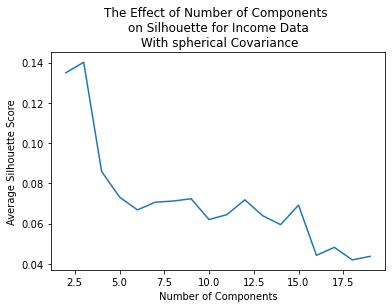

In [377]:
covariance_type = ['full', 'tied', 'diag', 'spherical']

for cv in covariance_type:
    run_em(X_Train_Income, np.arange(2, 20, 1), "Income Data", cv)

Data 2:
- Silhouette Max score occurs for n_components = 3 at 0.142
- Highest Silhouette occurs for covariance type = 'tied'
- BIC/AIC elbow method occurs for n_components = 5, heuristic method shows where decrease slows down

## Step 2) Apply Dimensionality Reduction Algorithms to the Datasets

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

Implement 4 Dimensionality Reduction Algorithms on the 2 Data sets
- PCA: Principal Components Analysis
- ICA: Independent Components Analysis
- RCA: Random Components Analysis 
- RFC: Random Forest Classifier

https://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues

### 2.1) PCA 

In [378]:
from sklearn.decomposition import PCA 

# No need to use Standard Scaler because we are using Binary Variables 

def run_PCA(X_Data, title):
    
    pca = PCA(n_components = .80, random_state = 42)
    pca.fit(X_Data)

    print("Optimal Number of Components:", pca.n_components_)
    max_feats = X_Data.shape[1]
    #max_feats = pca.n_components_

    plt.clf()
    #fig, (ax1, ax2) = plt.subplots(1,2)
    x = np.arange(1, pca.n_components_ +1)
    y1 = pca.explained_variance_ratio_.cumsum()
    plt.plot(x, y1)
    plt.plot(x, np.repeat(0.8, pca.n_components_), linestyle = '--', color = 'red')
    plt.ylabel("Cumulative Explained Variance")
    plt.xlabel("Number of Components")
    plt.title("The Effect of Number of Components \non Cumulative Explained Variance \nfor "+ title)
    plt.show()
    
    #print(pca.components_)
    #print(pca.singular_values_)
    
    y2 = pca.singular_values_
    plt.clf()
    plt.plot(x, y2)
    plt.xlabel("Number of Components")
    plt.ylabel("Eigenvalues")
    plt.title("The Effect of the Number of Components \non Eigenvalues for " + title)
    plt.show()

Optimal Number of Components: 31


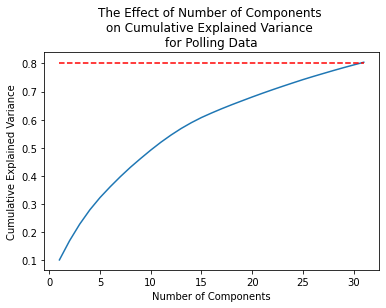

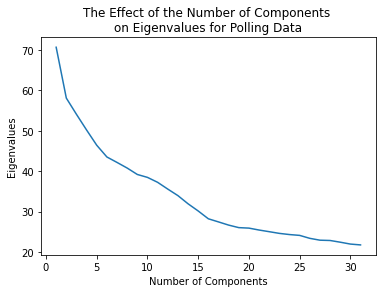

In [379]:
run_PCA(X_Train_Polling, "Polling Data")

Data #1
- Optimal Number of Components is 31

Optimal Number of Components: 19


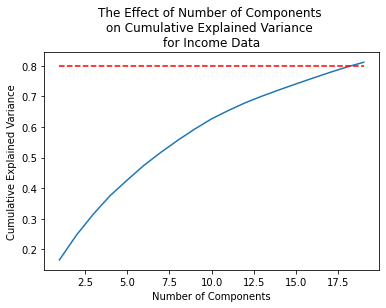

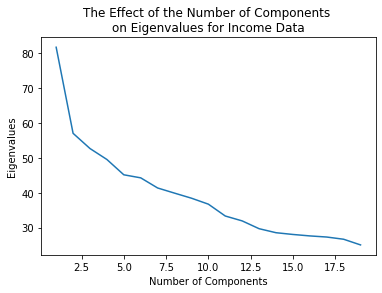

In [380]:
run_PCA(X_Train_Income, "Income Data")

Data #2
- Optimal Number of Components is 19
- Higher values of Eigenvalues is better, where n_components is 2 

### 2.2) ICA

ICA chart modified from: https://github.com/kylewest520/CS-7641---Machine-Learning/blob/master/Assignment%203%20Unsupervised%20Learning/CS%207641%20HW3%20Code.ipynb

In [469]:
from sklearn.decomposition import FastICA as ICA 

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

def run_ICA(X_Data, title):
    
    max_feats = X_Data.shape[1]
    
    n_components_list = np.arange(2, max_feats, 1)
    #n_components_list = np.arange(2, 30, 1)
    
    ica = ICA(random_state=42)
    kurtosis_list = []

    for num in n_components_list:
        
        ica.set_params(n_components=num)
        
        X_Transformed = ica.fit_transform(X_Data)
        #print(X_Transformed.shape)
        
        X_Transformed_df = pd.DataFrame(X_Transformed)
        #print(X_Transformed_df.shape)
        
        # Find the Kurtosis Over Requested Acxis, where 0 means find Kurtosis over rows 
        X_Transformed_Kurtosis = X_Transformed_df.kurt(axis=0) # Returns Series 
        
        avg_kurtosis = X_Transformed_Kurtosis.abs().mean()
       
        kurtosis_list.append(avg_kurtosis)
        
    plt.figure()
    plt.title("The Effect of the Indepdent Components \non The Average Kurtosis \nfor "+ title)
    plt.xlabel("Number of Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(n_components_list, kurtosis_list)
    plt.plot(n_components_list, np.repeat(3, len(n_components_list)), linestyle = '--', color = 'red')

    print(kurtosis_list)
    plt.grid(False)
    plt.show()

[1.131709511472693, 1.2547155182090055, 1.2275060076570872, 1.3172585392254257, 1.2139412570176151, 1.2021009447346311, 1.2576556973485638, 1.2243427852312512, 1.235041043470498, 1.2594495065390066, 1.2604807076389686, 1.3505790958495951, 1.401025370273739, 1.439391610125806, 1.5125299313566274, 1.5335881607683024, 1.8651703089577778, 1.9473113448679682, 2.0032156327971036, 1.95984650311873, 2.095131668540929, 2.1957680627142087, 2.3388958143684992, 2.646585918124056, 2.700947696293348, 2.820416580732614, 2.9159191054619726, 3.1122080147734663, 3.2661116455219825, 3.506293508515229, 3.5728913496237817, 3.7695033495284065, 4.196200055533861, 4.448782957893588, 4.564095276614467, 4.740633870778454, 5.180730047578088, 5.525809784438877, 5.807688316740107, 6.0350038588746555, 6.0903325558753485, 6.364135829335154, 6.926553437053599, 7.242065333373906, 7.588819938823955, 8.085106221176515, 8.27640741279714, 8.539649436821623, 9.2271303754392, 9.350036814008247, 9.612512354534257, 10.0658746

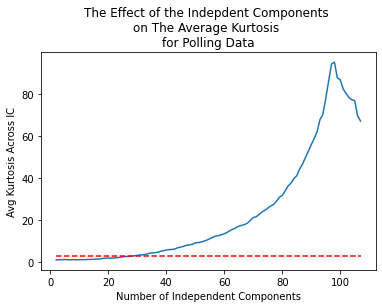

108.86962389945984


In [470]:
start = time.time()

run_ICA(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

- When number of IC components = 30, that is when Kurtosis > 3
- Kurtosis = 3 when a distribution is Normally Distributed
- Kurtosis >> 3 implies that there is a lot of weight in the tails of a distribution, measures many outliers
- ICA did not converge, even with 2000 max iterations, but values did not change by increasing 

[0.8101149071454676, 1.2238968784507718, 1.1836139718774663, 1.1853864281489916, 1.074620730640124, 1.1974117932963073, 1.3316357883983336, 1.229118255214117, 1.1731913545482582, 1.5030991859542049, 1.6770425962501212, 1.6502353793976128, 1.6141219504239088, 1.7381106912531166, 1.6981126475252106, 1.795701971254792, 2.217862781626916, 2.305896550420172, 2.484155055608634, 2.5834379912034198, 2.6955938289614685, 2.9973053038700863, 3.4096133015486365, 3.733929923864361, 4.0114533996336315, 4.496330342709199, 4.7061222017998645, 5.086835247150425, 5.430716869227711, 5.974045612219293, 6.611410539008532, 7.21610818263758, 7.8745222518017535, 8.624708339885512, 9.22811602184167, 10.040472170740902, 10.494488050320385, 11.6007523917733, 12.162768258774827, 12.732291191578117, 13.773740942662485, 14.47858579813754, 15.318614651555434, 16.673737807161363, 17.488027763359334, 19.034179379114143, 20.712226573694615, 21.98254073289437, 25.345286844719165, 27.693655817936413, 31.46851655058647, 3

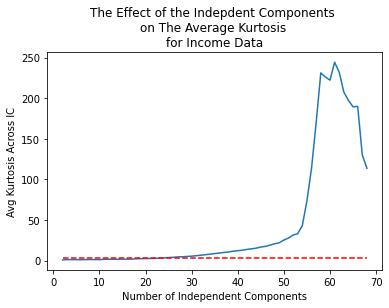

31.788501024246216


In [471]:
start = time.time()

run_ICA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Kurtosis stays much lower in this dataset through around 55 independent components, but then it shoots up over 200 kurtosis, which is much higher than Dataset 1 
- When number of IC equals 24, the Kurtosis Exceeds a value of 3

### 2.3) RCA 

In [511]:
def run_RPA2(X_Data, title):
    
    max_feats = X_Data.shape[1]
    n_components_list = np.arange(2, max_feats, 1)
    
    restarts = np.arange(1, 6, 1)
    list_of_lists = []
    
    for iteration in restarts:
        iterlist = []
        
        for num in n_components_list:

            rpa = GRP(n_components=num, random_state = iteration)

            # Fit to data using on n components 
            X_Reduced = rpa.fit_transform(X_Data)

            # Pseudo Inverse 
            psuedo_inverse = np.linalg.pinv(rpa.components_.T)
            X_Reconstructed = X_Reduced.dot(psuedo_inverse)

            Error_Recon = metrics.mean_squared_error(X_Data, X_Reconstructed)
            iterlist.append(Error_Recon)
            
        list_of_lists.append(iterlist)

    y1 = list_of_lists[0]
    y2 = list_of_lists[1]
    y3 = list_of_lists[2]
    y4 = list_of_lists[1]
    y5 = list_of_lists[2]
    
    plt.plot(n_components_list, y1)
    plt.plot(n_components_list, y2)
    plt.plot(n_components_list, y3)
    plt.plot(n_components_list, y4)
    plt.plot(n_components_list, y5)
    
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Number of Random Components")
    plt.title("The Effect of Number of Random Components \nOn The Reconstruction Error \nfor " + title)
    plt.show()


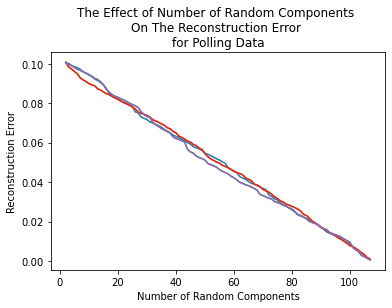

7.147708892822266


In [510]:
start = time.time()

run_RPA2(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end - start
print(elapsed)

- For Data #1, Reconstruction Error is minimized with maximum number of features included

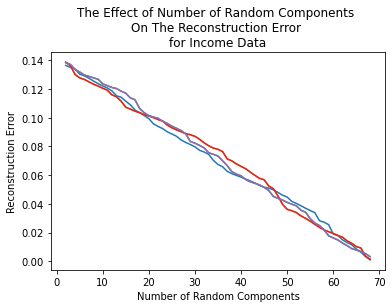

3.609762191772461


In [509]:
start = time.time()

run_RPA2(X_Train_Income, "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

- For RPA, Data # 2 has the least reconstruction error with the maximum number of components 

In [568]:
def run_RPA(X_Data, title):
    
    max_feats = X_Data.shape[1]
    n_components_list = np.arange(2, max_feats, 1)
    recon_error_list = []
    
    for num in n_components_list:

        rpa = GRP(n_components=num, random_state = 42)

        # Fit to data using on n components 
        X_Reduced = rpa.fit_transform(X_Data)

        psuedo_inverse = np.linalg.pinv(rpa.components_.T)
        X_Reconstructed = X_Reduced.dot(psuedo_inverse)

        Error_Recon = metrics.mean_squared_error(X_Data, X_Reconstructed)
        #print(Error_Recon)
        recon_error_list.append(Error_Recon)

    print(recon_error_list)
    plt.plot(n_components_list, recon_error_list)
    plt.plot(n_components_list, np.repeat(0.05, len(n_components_list)), linestyle = "--", color = 'red')
    plt.ylabel("Reconstruction Error")
    plt.xlabel("Number of Random Components")
    plt.title("The Effect of Number of Random Components \nOn The Reconstruction Error \nfor " + title)
    plt.show()


[0.10002087666361402, 0.09878744136807242, 0.09777629060973039, 0.09615230765955138, 0.09553275743016994, 0.0946188368303681, 0.09365362653418463, 0.09306300202347277, 0.0921779272099791, 0.09140392997449617, 0.09080338323213455, 0.08998337673574595, 0.08944159493025869, 0.08859878166030098, 0.08805232427248867, 0.08699537590074156, 0.08628064968961022, 0.08571109189944774, 0.08504181283821532, 0.08434438544141143, 0.08329846250002726, 0.08185037492648475, 0.07956023355465766, 0.07910309795280471, 0.0786262117550086, 0.07734646147247316, 0.07674674092080545, 0.07621323409023596, 0.07565172974855933, 0.07415825763601099, 0.07346912279399882, 0.07238510295472965, 0.07170763657943573, 0.06992922459758623, 0.06914826729604198, 0.06851884685380442, 0.06722339010318641, 0.06657043140581721, 0.06569929883860322, 0.0652331337535151, 0.06477835315715381, 0.06396881618799052, 0.0631257829166733, 0.062113271175503595, 0.06127632358840844, 0.06075654245983825, 0.060282735511021666, 0.0590135411129

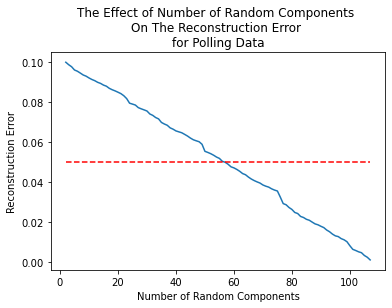

1.6557509899139404


In [569]:
start = time.time()

run_RPA(X_Train_Polling, "Polling Data")

end = time.time()

elapsed = end - start
print(elapsed)

- Data #1 requires 58 components to have under a 5% reconstruction error rate

[0.14253329206994736, 0.14058081710724793, 0.1394550800423798, 0.13793771524385923, 0.1362893399632252, 0.13517252802627236, 0.13078458227671505, 0.1282309955423928, 0.126821085920012, 0.12468747200820236, 0.12207351960020364, 0.11807496782434479, 0.11585071179483081, 0.11342749992683646, 0.1095466528834968, 0.10608398843152263, 0.10516522199377282, 0.104444274280405, 0.10070073677010757, 0.09732312622016068, 0.09276492256977895, 0.09181566053967509, 0.09053006262279438, 0.0877872113417717, 0.0865233275175988, 0.0845085905659909, 0.08306480434396293, 0.08097918513891145, 0.07979250422427994, 0.07786984695152979, 0.07644315497989332, 0.07508096960165041, 0.07300037085195946, 0.06771181764809092, 0.06646070966644495, 0.06424001749475113, 0.06183346827410797, 0.0605764101842776, 0.05571282894858738, 0.05339015417345185, 0.05171695972770273, 0.050621574115670705, 0.04953581194140921, 0.04813696175846462, 0.045695992768353975, 0.04365854751017933, 0.03831823217859165, 0.035796786758481074, 

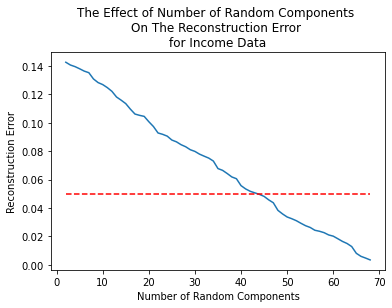

0.8124868869781494


In [570]:
start = time.time()

run_RPA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end - start
print(elapsed)

- Data #2 requires 44 components to have under a 5% reconstruction error 

In [612]:
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from sklearn.metrics.pairwise import pairwise_distances

max_feats = X_Train_Polling.shape[1]

#n_components_list = np.arange(2, max_feats, 1)
n_components_list = np.arange(2, 6, 1)

for num in n_components_list:
    print("num components:" , num)
    grp = RCA(random_state = 42, n_components = num)
    grp.fit(X_Train_Polling)

    X_Train_Recon = pairwise_distances(grp.fit_transform(X_Train_Polling))
    X_Train = pairwise_distances(X_Train_Polling)

    corr = np.corrcoef(X_Train_Recon.ravel(), X_Train.ravel())[0, 1]
    print(corr)

num components: 2
0.25849682065817037
num components: 3
0.26079085040917693
num components: 4
0.34023314234064744
num components: 5
0.38830320345322517


In [460]:
from collections import defaultdict
from sklearn.random_projection import GaussianRandomProjection as GRP, SparseRandomProjection as RCA
from itertools import product

def run_RCA(X_Data, title):
    
    dims = list(np.arange(2,(X_Data.shape[1]-1),3))
    dims.append(X_Data.shape[1])
    tmp = defaultdict(dict)

    # Run RCA 5 Times, and get the Average Reconstruction Correlation
    for i,dim in product(range(5),dims):
        
        rca = RCA(random_state=i, n_components=dim)
        
        X_Train_Recon = pairwise_distances(rca.fit_transform(X_Data))
        X_Train = pairwise_distances(X_Data)
        
        tmp[dim][i] = np.corrcoef(X_Train_Recon.ravel(), X_Train.ravel())[0, 1]
        #print(tmp[dim][i])
        
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()

    print(mean_recon)
    
    fig, ax1 = plt.subplots()
    ax1.plot(dims, mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims, std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()

[0.19539200770372916, 0.2912331718506799, 0.39708606225552384, 0.43755886706128333, 0.4838301733711942, 0.5315415212963007, 0.5596444842155346, 0.5782284017139171, 0.6100204295273706, 0.6171131738776469, 0.624136062214659, 0.6462761590632542, 0.6865035317502431, 0.6915212037804687, 0.7045472013932843, 0.710393988665335, 0.7145004653135058, 0.7277507454357237, 0.7454135450438978, 0.7481007575564964, 0.7448001180950052, 0.7654186673834195, 0.7628957788803898, 0.7766109912624354, 0.7877421400891341, 0.7895375411368665, 0.7943859359362576, 0.7973683425435475, 0.8067599191845476, 0.812843562208295, 0.8126734848613367, 0.8273892628839088, 0.8307971761359221, 0.8285842163184283, 0.8379472159550806, 0.8353247026893758]


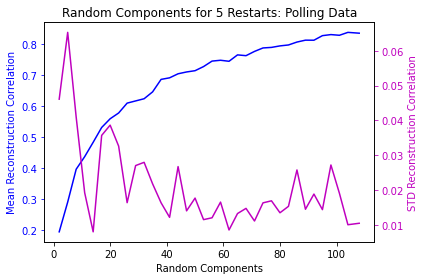

1654.3009939193726


In [461]:
start = time.time()

run_RCA(X_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Data1 has a good Mean and lower standard deviation once we have more than 40 components in the model 

[0.3328670230287288, 0.43524244726954686, 0.49864371888438547, 0.562426668441221, 0.5923143136069859, 0.6402653334926788, 0.6641173175262397, 0.6699411078518283, 0.7236272236496509, 0.7432258697839242, 0.7724082207225235, 0.7685822684287463, 0.770728399919584, 0.7904478581976389, 0.8077692364955213, 0.8118497125790908, 0.8195627281956138, 0.8228874436243133, 0.8361119818197056, 0.8477014027272304, 0.8503209363695919, 0.8563865642892683, 0.8667305849766626]


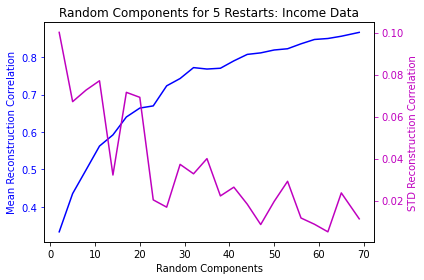

245.13268995285034


In [462]:
start = time.time()

run_RCA(X_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

### Step 2.4) Random Forest Classifier

We can use Y in this Dimensionality Reduction Algorithm

In [545]:
from sklearn.ensemble import RandomForestClassifier as RFC

# How many features do we need to get 95% of feature importance? 
def RFC_min_samples_leaf(X_Data, Y_Data, title):
    
    # The Data is 7000 rows long, 70 is 1% of that 
    num_samples_leaf = np.arange(2, 72, 1)
    num_components_list = []
    
    for num in num_samples_leaf:
    
        rfc = RFC(n_estimators=100, min_samples_leaf= num, random_state=42)
        importances = rfc.fit(X_Data, Y_Data).feature_importances_ 

        importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
        importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
        importances['Cum Sum'] = importances['Feature Importance'].cumsum()
        importances = importances[importances['Cum Sum']<=0.95]
        top_cols = importances.index.tolist()

        #return (importances, top_cols)
        num_components_list.append(len(top_cols))
        
    plt.plot(num_samples_leaf, num_components_list)
    plt.xlabel("Number of Min Leaf Samples")
    plt.ylabel("Number of Components to get 95%")
    plt.title("The Effect of Min Leaf Samples Size \nOn Number of Components in Random Forest \nFor "+ title)
    plt.show()
    

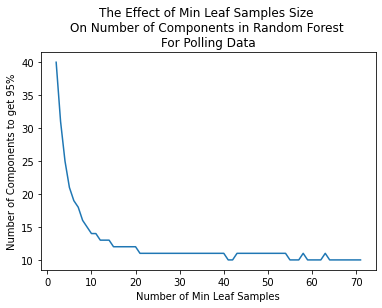

27.847368001937866


In [546]:
start = time.time()

RFC_min_samples_leaf(X_Train_Polling, Y_Train_Polling, "Polling Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Data # 1 should have 12 as the min_samples_leaf size

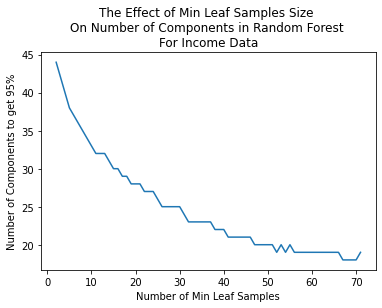

23.412508249282837


In [547]:
start = time.time()

RFC_min_samples_leaf(X_Train_Income, Y_Train_Income, "Income Data")

end = time.time()
elapsed = end-start
print(elapsed)

- Data #2 should have ~47 as the min_samples_leaf size 

In [618]:
from sklearn.ensemble import RandomForestClassifier as RFC

# How many features do we need to get 95% of feature importance? 
def run_RFC(X_Data, Y_Data, min_samples):
    
    rfc = RFC(n_estimators=100, min_samples_leaf=min_samples, random_state=42)
    
    importances = rfc.fit(X_Data, Y_Data).feature_importances_ 
    
    importances = pd.DataFrame(importances,columns=['Feature Importance'],index=X_Data.columns)
    importances.sort_values(by=['Feature Importance'],inplace=True,ascending=False)
    importances['Cum Sum'] = importances['Feature Importance'].cumsum()
    importances = importances[importances['Cum Sum']<=0.95]
    top_cols = importances.index.tolist()
    
    return (importances, top_cols)

In [619]:
importances, top_cols = run_RFC(X_Train_Polling, Y_Train_Polling, 12)

print(importances.shape)

importances

(13, 2)


,Feature Importance,Cum Sum
approval_pres_Strongly Disapprove,0.397137,0.397137
approval_pres_Strongly Approve,0.187498,0.584635
economy_retro_Gotten Much Better,0.105779,0.690414
approval_pres_Approve / Somewhat Approve,0.082038,0.772452
economy_retro_Stayed About The Same,0.035982,0.808434
economy_retro_Gotten Worse / Somewhat Worse,0.031179,0.839612
economy_retro_Gotten Better / Somewhat Better,0.026024,0.865636
race_Black,0.025846,0.891483
race_White,0.018611,0.910093
approval_pres_Disapprove / Somewhat Disapprove,0.013091,0.923185


- Dataset #1 Only requires 13 features to explain 95% of the results, using Random Forest Classifer 

In [620]:
importances, top_cols  = run_RFC(X_Train_Income, Y_Train_Income, 47)

print(importances.shape)

importances

(20, 2)


,Feature Importance,Cum Sum
marital.status_Married-civ-spouse,0.222067,0.222067
relationship_Husband,0.157912,0.379979
age_band_Young,0.071949,0.451929
marital.status_Never-married,0.060349,0.512278
occupation_Exec-managerial,0.054112,0.566390
hours_band_High,0.053364,0.619754
education_Bachelors,0.043697,0.663451
occupation_Prof-specialty,0.042281,0.705732
hours_band_Low,0.031157,0.736889
sex_Female,0.026713,0.763602


- Dataset #2, only Needs 19 components to get 95% of the feature importance using Random Forest Classifier

## Step 3)

In [602]:
pca = PCA(n_components = 31, random_state = 42)
pca.fit(X_Train_Polling)
pca.components_

kmeans = KMeans(init = pca.components_, n_clusters = 31, n_init =1, random_state = 42)
kmeans.fit(X_Train_Polling)

print("Inertia", kmeans.inertia_)
print("Labels:", kmeans.labels_)


s_score = silhouette_score(X_Train_Polling, kmeans.labels_ )
print(s_score)

Inertia 33673.02886766231
Labels: [ 2 27  4 ... 13  0  0]
0.052822607933396284


### Step 3) Data 1 

In [613]:
pca_X_Train_Polling = PCA(n_components = 31, random_state = 42).fit_transform(X_Train_Polling)
ica_X_Train_Polling = ICA(n_components = 30, random_state = 42).fit_transform(X_Train_Polling)
rca_X_Train_Polling = GRP(n_components = 58, random_state = 42).fit_transform(X_Train_Polling)

In [632]:
top_cols_df, top_cols = run_RFC(X_Train_Polling, Y_Train_Polling, 12)
rfc_X_Train_Polling = X_Train_Polling[top_cols] 

### Step 3) Data 1 With K-Means

Step 3.1) Data 1 With K-Means with PCA 

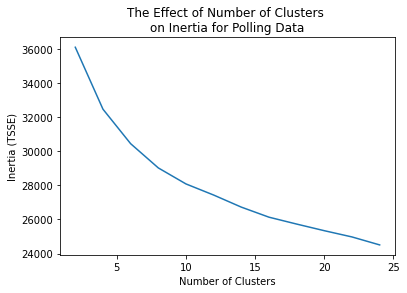

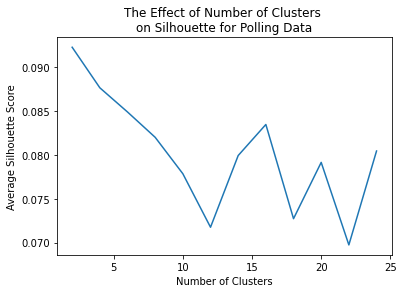

In [614]:
run_kmeans(pca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data")

Step 3.2) Data 1 With K-Means with ICA

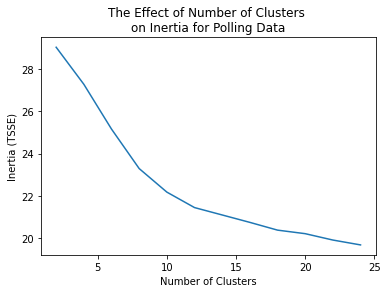

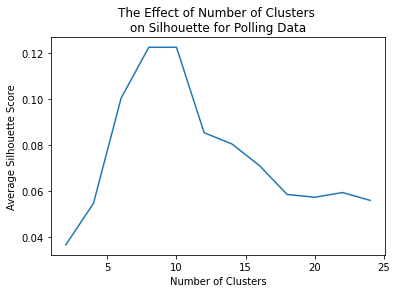

In [615]:
run_kmeans(ica_X_Train_Polling, np.arange(2, 25, 2), "Polling Data")

- ICA for Data 1, reduced dataset, shows that the optimal number of clusters may not be 2 if we are using ICA 
- Optimal Clusters is 8 - 11

Step 3.3) Data 1 With K-Means with RCA 

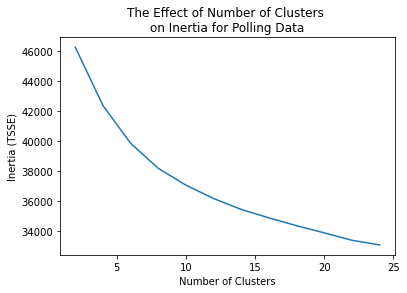

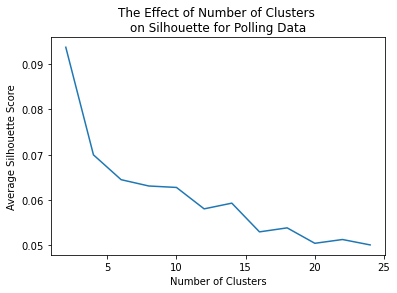

In [616]:
run_kmeans(rpa_X_Train_Polling, np.arange(2, 25, 2), "Polling Data")

Step 3.4) Data 1 with K-Means and RFC 

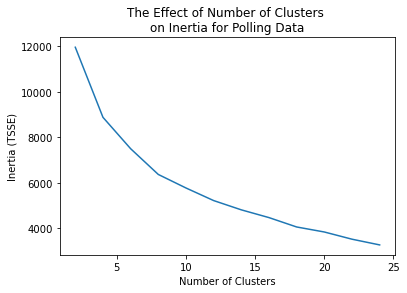

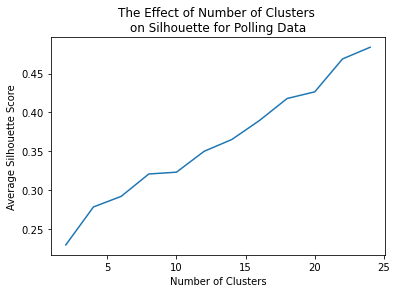

In [633]:
run_kmeans(rfc_X_Train_Polling, np.arange(2, 25, 2), "Polling Data" )

### Step 3) Data 1 With EM

3.5) Data 1 With EM with PCA 

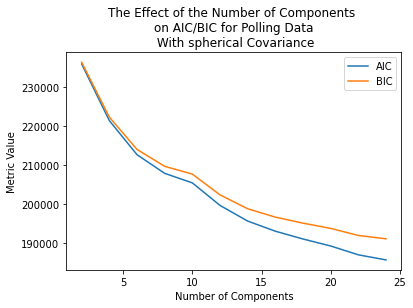

Silhouettes [0.09230764122148996, 0.07761773155944246, 0.07582876196043235, 0.07456619063328039, 0.057672295391423295, 0.07071096679299056, 0.06713758346487085, 0.07466605744351701, 0.069431153772913, 0.06184220467369414, 0.05316383397315207, 0.047440452710365746]


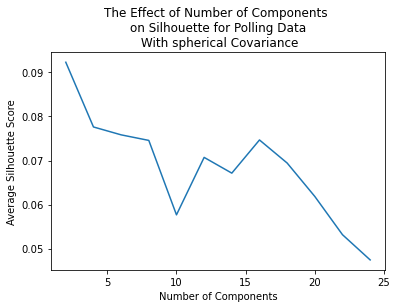

In [635]:
run_em(pca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'spherical')

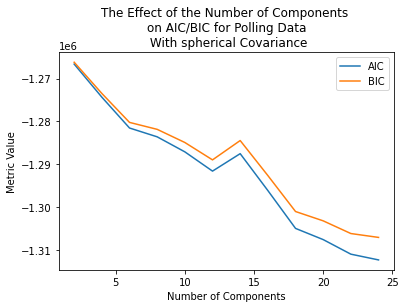

Silhouettes [-0.08027739703851483, -0.0436854086236598, 0.0019648138530744307, 0.015129954950335986, 0.0043505633010359705, 0.005952530039509609, 0.044092942178641216, 0.029364503446816046, 0.050881848887868564, 0.05135950788280338, 0.014191942941806495, 0.014927114074962514]


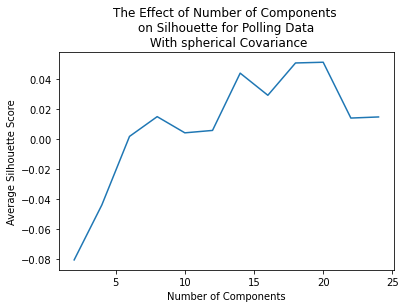

In [636]:
run_em(ica_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'spherical')

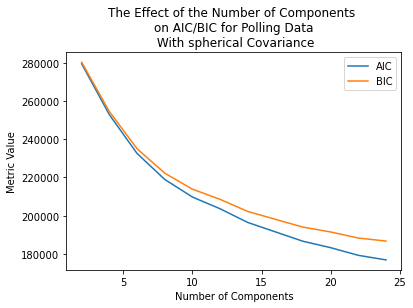

Silhouettes [0.09252054263486931, 0.07050823822678291, 0.05577919898830095, 0.05499607333488237, 0.05837278225529546, 0.05252528020499381, 0.05475919271335787, 0.04820741495528026, 0.04225294852656542, 0.04240241616340427, 0.041277221832894014, 0.04340080001545388]


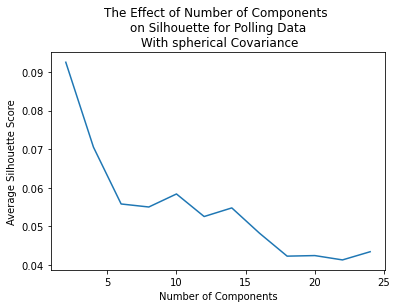

In [637]:
run_em(rca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'spherical')

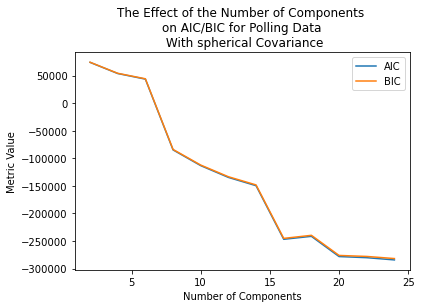

Silhouettes [0.1854490686511494, 0.17100506220351488, 0.22911426081625694, 0.2309885578979665, 0.2601426314882562, 0.27841608910791305, 0.31703938256954006, 0.34927943315919563, 0.4020542038129833, 0.4281870075345365, 0.45468955848947085, 0.4658023182445024]


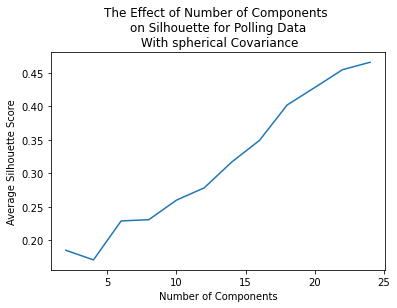

In [638]:
run_em(rfc_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'spherical')

### Step 3) Data 2

In [641]:
pca_X_Train_Income = PCA(n_components = 19, random_state = 42).fit_transform(X_Train_Income)
ica_X_Train_Income = ICA(n_components = 24, random_state = 42).fit_transform(X_Train_Income)
rca_X_Train_Income = GRP(n_components = 44, random_state = 42).fit_transform(X_Train_Income)

top_cols_df, top_cols = run_RFC(X_Train_Income, Y_Train_Income, 47)
rfc_X_Train_Income = X_Train_Income[top_cols] 

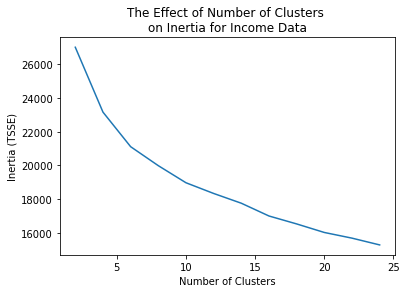

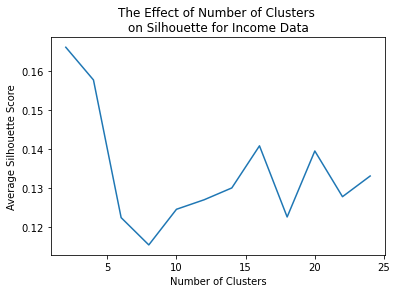

In [644]:
run_kmeans(pca_X_Train_Income, np.arange(2, 25, 2), "Income Data")

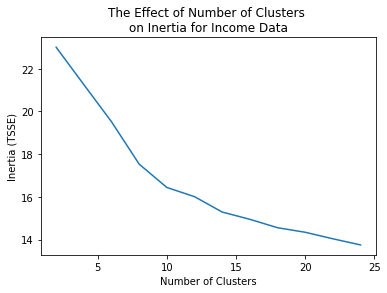

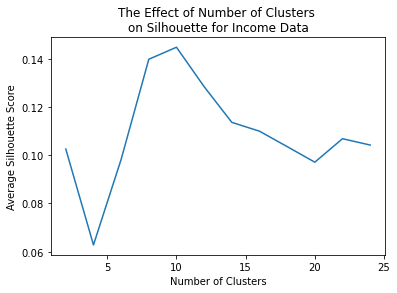

In [645]:
run_kmeans(ica_X_Train_Income, np.arange(2, 25, 2), "Income Data")

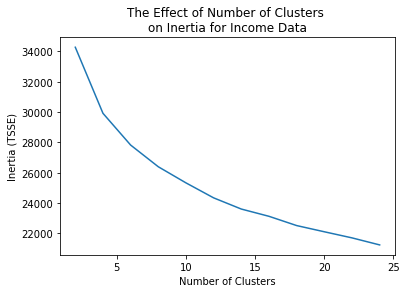

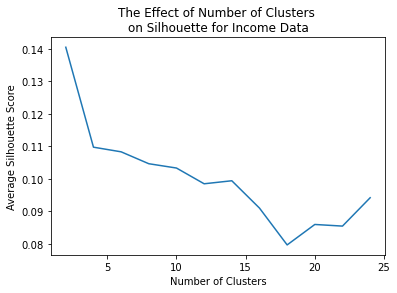

In [646]:
run_kmeans(rca_X_Train_Income, np.arange(2, 25, 2), "Income Data")

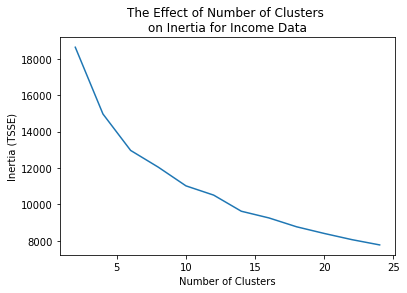

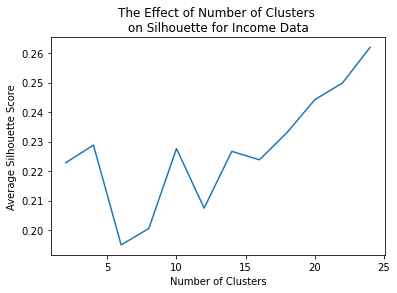

In [647]:
run_kmeans(rfc_X_Train_Income, np.arange(2, 25, 2), "Income Data")

Data 2 on EM

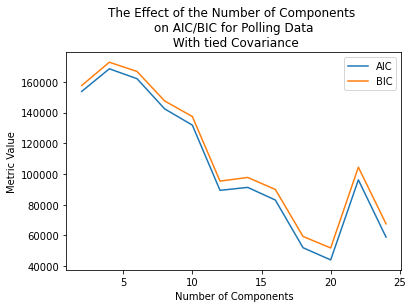

Silhouettes [0.09230764122148996, 0.07557817460850014, 0.07709745105699545, 0.07293957857657472, 0.06434402924460039, 0.07486112404257066, 0.06371846391571025, 0.07269571423170419, 0.07168216103735423, 0.05828597435611543, 0.0643549799837993, 0.06034306151759679]


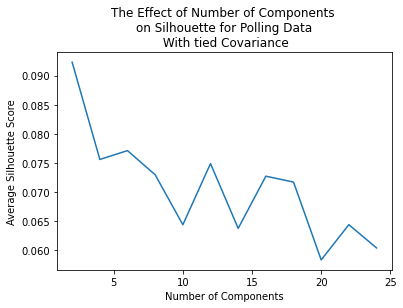

In [648]:
run_em(pca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'tied')

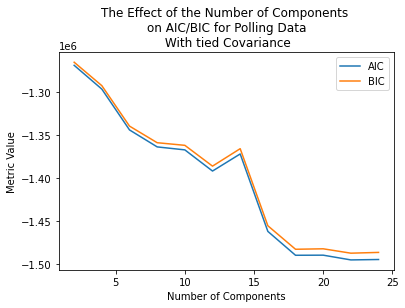

Silhouettes [0.03142708031418075, 0.05322950398917344, 0.06476878514430767, 0.06908150319118311, 0.06971234533893911, 0.07465644413799889, 0.07050590351350307, 0.06951959228225307, 0.06782630772323503, 0.06191165779243845, 0.029057135996922504, 0.020467318079976256]


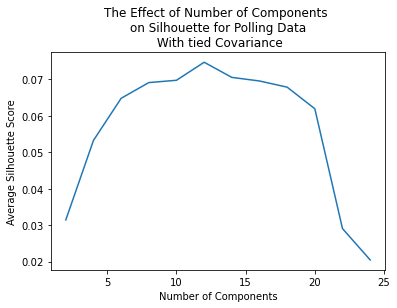

In [649]:
run_em(ica_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'tied')

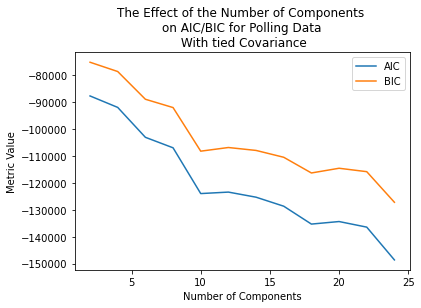

Silhouettes [0.07043830257498593, 0.06442554540157981, 0.036798450780342266, 0.05539317512954191, 0.05048126724039104, 0.04556167930113839, 0.04707549507869531, 0.028514748142335393, 0.03593264156562102, 0.024543043502292583, 0.014101946777848075, 0.02539863477050336]


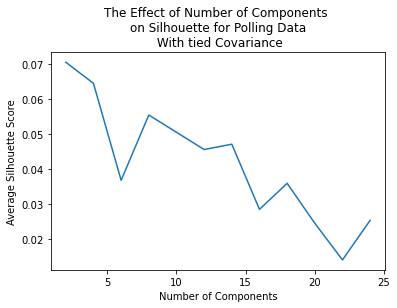

In [650]:
run_em(rca_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'tied')

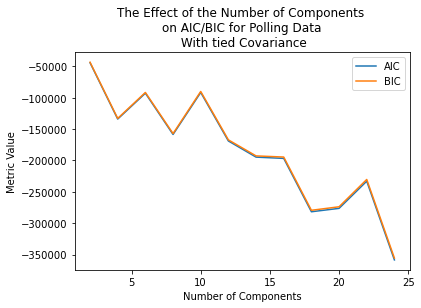

Silhouettes [0.224692188152751, 0.24260834207294998, 0.2910648073889838, 0.283625304492473, 0.2997329789843253, 0.3190971507313636, 0.3732203753353009, 0.37995372019716145, 0.38260551944634735, 0.41078460428440755, 0.43162875548666724, 0.4451482646509381]


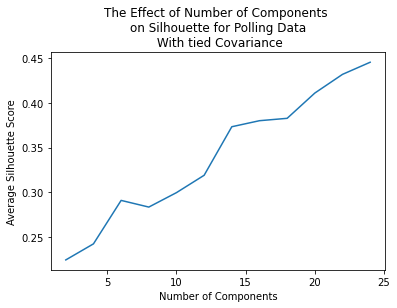

In [651]:
run_em(rfc_X_Train_Polling, np.arange(2, 25, 2), "Polling Data", 'tied')